In [1]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import AutoEncoder, train_model, CombinedLoss
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler

# Data Loading

In [2]:
# load data from s3 storage
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,…,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_responder_0_lagged,feature_responder_1_lagged,feature_responder_2_lagged,feature_responder_3_lagged,feature_responder_4_lagged,feature_responder_5_lagged,feature_responder_6_lagged,feature_responder_7_lagged,feature_responder_8_lagged,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,symbol_id,time_id,weight
i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,f32
0,0.127298,0.339121,-0.045494,0.151473,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,-0.059343,-0.751958,-0.314242,…,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,1,35,3.889038
0,0.114208,-1.419921,-0.505525,-0.258195,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,-0.059218,-0.298613,0.029315,…,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,1,36,3.889038
0,0.118826,-1.293755,-0.809856,0.268584,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,-0.019658,-0.084493,-0.116301,…,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,1,37,3.889038
0,-0.216346,-0.021069,-0.425764,-0.005701,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,0.207732,-0.046667,-0.266864,…,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,1,38,3.889038
0,-0.660073,2.168059,0.903407,-0.101644,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.014473,-0.

In [3]:
# we pick responder_6 as the target (same target as the data challenge)
target = "responder_6"
features = [col for col in data.columns if "feature" in col]
X, y = data[features], data[target]

n = X.height
n_train = int(0.8 * n)
X_train_raw = X.slice(0, n_train)
y_train_raw = y.slice(0, n_train)
X_val_raw = X.slice(n_train)
y_val_raw = y.slice(n_train)

# Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# We use .to_numpy() for the scalers
x_train_np = scaler_x.fit_transform(X_train_raw.to_numpy())
# Important: y must be 2D for the scaler
y_train_np = scaler_y.fit_transform(y_train_raw.to_numpy().reshape(-1, 1))

x_val_np = scaler_x.transform(X_val_raw.to_numpy())
y_val_np = scaler_y.transform(y_val_raw.to_numpy().reshape(-1, 1))

# Dataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, X_np, y_np):
        # We store them as tensors directly to avoid re-converting at each __getitem__
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Instantiation
train_dataset = TimeSeriesDataset(x_train_np, y_train_np)
val_dataset = TimeSeriesDataset(x_val_np, y_val_np)

# Loader
train_data_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=8)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

# Model Evaluation

  5%|▌         | 1/20 [00:09<02:55,  9.23s/it]

Epoch 01 | loss=179.974 | R2_rec_train=0.2138 | R2_rec_val=0.0739 | R2_sup_train=0.7693 | R2_sup_val=0.7981


 10%|█         | 2/20 [00:17<02:37,  8.77s/it]

Epoch 02 | loss=138.333 | R2_rec_train=0.3453 | R2_rec_val=0.2102 | R2_sup_train=0.8277 | R2_sup_val=0.8297


 15%|█▌        | 3/20 [00:26<02:26,  8.61s/it]

Epoch 03 | loss=133.301 | R2_rec_train=0.4066 | R2_rec_val=0.2450 | R2_sup_train=0.8303 | R2_sup_val=0.8326


 20%|██        | 4/20 [00:34<02:18,  8.65s/it]

Epoch 04 | loss=131.648 | R2_rec_train=0.4286 | R2_rec_val=0.2887 | R2_sup_train=0.8309 | R2_sup_val=0.8410


 25%|██▌       | 5/20 [00:43<02:09,  8.62s/it]

Epoch 05 | loss=130.131 | R2_rec_train=0.4453 | R2_rec_val=0.3300 | R2_sup_train=0.8319 | R2_sup_val=0.8419


 30%|███       | 6/20 [00:51<01:58,  8.49s/it]

Epoch 06 | loss=128.853 | R2_rec_train=0.4663 | R2_rec_val=0.3424 | R2_sup_train=0.8320 | R2_sup_val=0.8350


 35%|███▌      | 7/20 [01:00<01:50,  8.51s/it]

Epoch 07 | loss=127.643 | R2_rec_train=0.4751 | R2_rec_val=0.3198 | R2_sup_train=0.8331 | R2_sup_val=0.8473


 40%|████      | 8/20 [01:07<01:37,  8.12s/it]

Epoch 08 | loss=126.902 | R2_rec_train=0.4875 | R2_rec_val=0.3212 | R2_sup_train=0.8331 | R2_sup_val=0.8450


 45%|████▌     | 9/20 [01:14<01:26,  7.83s/it]

Epoch 09 | loss=125.915 | R2_rec_train=0.4957 | R2_rec_val=0.3713 | R2_sup_train=0.8339 | R2_sup_val=0.8449


 50%|█████     | 10/20 [01:22<01:17,  7.80s/it]

Epoch 10 | loss=125.409 | R2_rec_train=0.5000 | R2_rec_val=0.3802 | R2_sup_train=0.8344 | R2_sup_val=0.8487


 55%|█████▌    | 11/20 [01:30<01:10,  7.80s/it]

Epoch 11 | loss=125.310 | R2_rec_train=0.4994 | R2_rec_val=0.3742 | R2_sup_train=0.8348 | R2_sup_val=0.8465


 60%|██████    | 12/20 [01:37<01:01,  7.72s/it]

Epoch 12 | loss=124.713 | R2_rec_train=0.5068 | R2_rec_val=0.3638 | R2_sup_train=0.8350 | R2_sup_val=0.8389


 65%|██████▌   | 13/20 [01:45<00:55,  7.86s/it]

Epoch 13 | loss=124.738 | R2_rec_train=0.5071 | R2_rec_val=0.3860 | R2_sup_train=0.8350 | R2_sup_val=0.8473


 70%|███████   | 14/20 [01:52<00:45,  7.62s/it]

Epoch 14 | loss=125.067 | R2_rec_train=0.4984 | R2_rec_val=0.3255 | R2_sup_train=0.8353 | R2_sup_val=0.8463


 75%|███████▌  | 15/20 [02:00<00:37,  7.46s/it]

Epoch 15 | loss=125.688 | R2_rec_train=0.4844 | R2_rec_val=0.3276 | R2_sup_train=0.8357 | R2_sup_val=0.8483


 80%|████████  | 16/20 [02:07<00:30,  7.55s/it]

Epoch 16 | loss=125.203 | R2_rec_train=0.4906 | R2_rec_val=0.3944 | R2_sup_train=0.8358 | R2_sup_val=0.8479


 85%|████████▌ | 17/20 [02:15<00:22,  7.45s/it]

Epoch 17 | loss=124.810 | R2_rec_train=0.4977 | R2_rec_val=0.3961 | R2_sup_train=0.8358 | R2_sup_val=0.8500


 90%|█████████ | 18/20 [02:22<00:14,  7.35s/it]

Epoch 18 | loss=123.689 | R2_rec_train=0.5113 | R2_rec_val=0.3833 | R2_sup_train=0.8363 | R2_sup_val=0.8464


 95%|█████████▌| 19/20 [02:29<00:07,  7.47s/it]

Epoch 19 | loss=123.620 | R2_rec_train=0.5135 | R2_rec_val=0.3886 | R2_sup_train=0.8363 | R2_sup_val=0.8506


100%|██████████| 20/20 [02:37<00:00,  7.86s/it]

Epoch 20 | loss=123.518 | R2_rec_train=0.5131 | R2_rec_val=0.3844 | R2_sup_train=0.8364 | R2_sup_val=0.8479


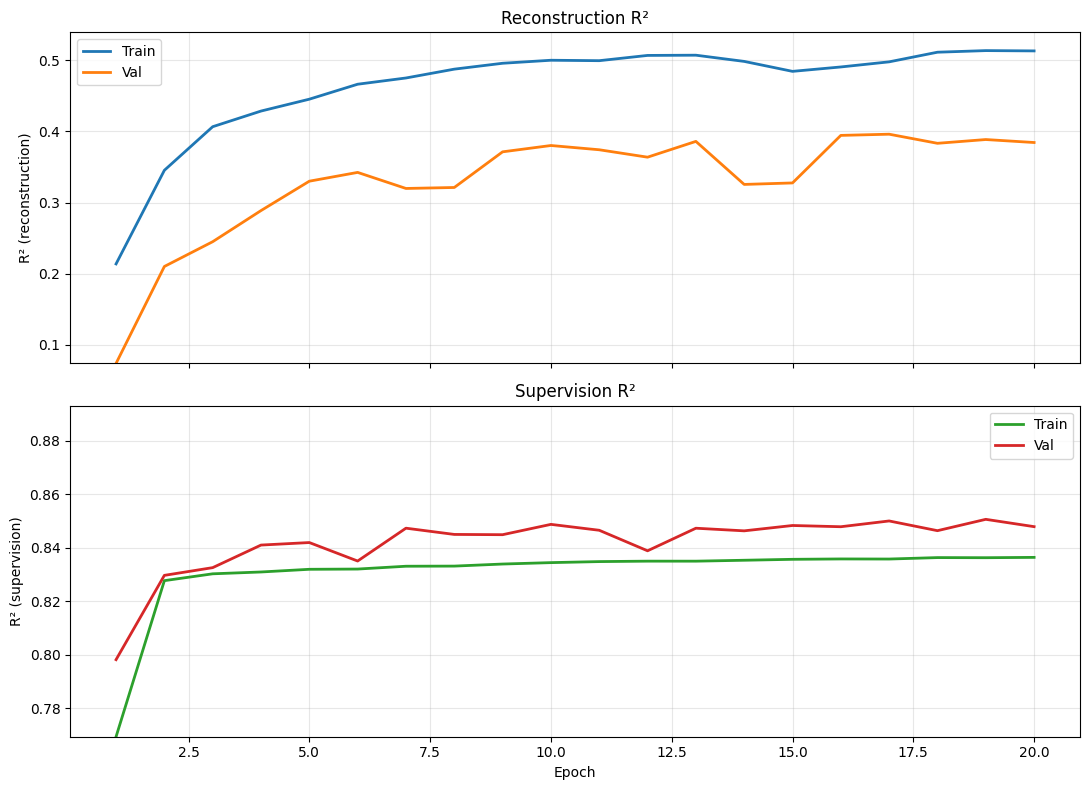

In [4]:
# define model
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 8, 4]
activation = torch.nn.LeakyReLU

model = AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    activation=activation
)

# define optimization parameters
lr = 0.5e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha = 0.1
beta = 1.0

optimizer = Adam(model.parameters(), lr=lr)
criterion = CombinedLoss(alpha=alpha, beta=beta)
n_epochs = 20

train = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
)

# Extract latent representation

In [7]:
import polars as pl

def extract_latent_with_ids(model, dataset, device, batch_size=32):
    """
    Extracts latent features and preserves temporal identifiers.
    """
    model.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    latent_list = []
    
    with torch.no_grad():
        for batch_x, _ in loader:
            batch_x = batch_x.to(device)
            z, _, _ = model(batch_x)
            latent_list.append(z.cpu())
            
    z_tensor = torch.cat(latent_list, dim=0)
    
    n_latent = z_tensor.shape[1]
    df_latent = pl.DataFrame(
        z_tensor.numpy(), 
        schema=[f"latent_{i}" for i in range(n_latent)]
    )
    
    return df_latent

def merge_latent_with_original(df_original, df_latent, seq_len):
    """
    Merges latent features with original identifiers.
    The latent features for index i correspond to the window ending at seq_len + i - 1.
    """
    df_ids = df_original.select(["date_id", "time_id"]).slice(seq_len)
    
    if len(df_ids) != len(df_latent):
        df_ids = df_original.select(["date_id", "time_id"]).tail(len(df_latent))

    return pl.concat([df_ids, df_latent], how="horizontal")

df_z_train_raw = extract_latent_with_ids(model, train_dataset, device)
df_z_val_raw = extract_latent_with_ids(model, val_dataset, device)

df_z_train = merge_latent_with_original(data.slice(0, n_train), df_z_train_raw, seq_len=50)
df_z_val = merge_latent_with_original(data.slice(n_train), df_z_val_raw, seq_len=50)

print(df_z_train.head())

shape: (5, 18)
┌─────────┬─────────┬───────────┬────────────┬───┬───────────┬───────────┬────────────┬────────────┐
│ date_id ┆ time_id ┆ latent_0  ┆ latent_1   ┆ … ┆ latent_12 ┆ latent_13 ┆ latent_14  ┆ latent_15  │
│ ---     ┆ ---     ┆ ---       ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---        ┆ ---        │
│ i16     ┆ i16     ┆ f32       ┆ f32        ┆   ┆ f32       ┆ f32       ┆ f32        ┆ f32        │
╞═════════╪═════════╪═══════════╪════════════╪═══╪═══════════╪═══════════╪════════════╪════════════╡
│ 0       ┆ 35      ┆ -7.035804 ┆ -21.708277 ┆ … ┆ 14.144685 ┆ 0.806835  ┆ -28.158043 ┆ -13.309478 │
│ 0       ┆ 36      ┆ -5.018076 ┆ -17.70989  ┆ … ┆ 14.868445 ┆ -0.912274 ┆ -24.084221 ┆ -10.561488 │
│ 0       ┆ 37      ┆ -2.001727 ┆ -9.486371  ┆ … ┆ 9.737614  ┆ -0.505369 ┆ -12.443679 ┆ -7.487733  │
│ 0       ┆ 38      ┆ -4.148824 ┆ -10.941501 ┆ … ┆ 9.343284  ┆ -0.317935 ┆ -12.922382 ┆ -7.495865  │
│ 0       ┆ 39      ┆ -3.166654 ┆ -13.113809 ┆ … ┆ 9.552634  ┆ -0.076872 ┆ -

In [8]:
# save datasets
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/latent_X_train.parquet"
reader.save_parquet(df_z_train, FILE_KEY_S3)

BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/latent_X_val.parquet"
reader.save_parquet(df_z_val, FILE_KEY_S3)